In [1]:
from utils.config import Project_Config
from utils.custom_enums import Dataset_Type_Enum, Model_Type_Enum

model_type = Model_Type_Enum.LORA
dataset_type = Dataset_Type_Enum.CIFAR2

MODEL_NAME_CLEAN = f"sd1-{model_type}"

#How many images to generate per prompt
NUM_SEEDS_TO_GENERATE = 20

GENERATE_NSFW_DISTRIBUTION_DATA = False

project_config = Project_Config()

f = project_config.folder_symbol
base_save_path = (project_config.PWD + f + 
                  "datasets" + f +
                  f"generated-{dataset_type}" + f +
                  MODEL_NAME_CLEAN)

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
from diffusers import DiffusionPipeline
import torch

import os
p = (
    project_config.PWD + f + 
    "models" + f +
    dataset_type + f +  
    MODEL_NAME_CLEAN
)
print(p)
assert(os.path.isdir(p))

if model_type == Model_Type_Enum.LORA:
    p = p + project_config.folder_symbol + "pytorch_lora_weights.safetensors"
    pipe = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16)
    if project_config.IS_CUDA:
        pipe.to("cuda")
    pipe.load_lora_weights(p)
else: #if model_type == Model_Type_Enum.FULL
    pipe = DiffusionPipeline.from_pretrained(p)
    if project_config.IS_CUDA:
        pipe.to("cuda")
print("") #Stop ipynb dumping rubbish after this block

/home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/models/cifar2/sd1-lora


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


In [3]:
#This trick is directly based of something I found from DTRAK's code, see:
#https://github.com/sail-sg/D-TRAK/blob/main/ArtBench5/train_text_to_image_lora.py 
#line 1029 (at time of writing)
#Notably, their version does not work as is in current versions of diffusers, 
# and requires this slight adaption (creating a list of bools rather than a single bool)

def dummy(images, **kwargs):
        return images, [False]*len(images)

if GENERATE_NSFW_DISTRIBUTION_DATA == False:
        pipe.safety_checker = dummy

100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


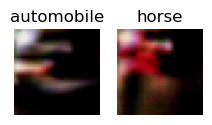

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

if dataset_type == Dataset_Type_Enum.CIFAR10:
    prompts=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'ship', 'truck', 'frog']
if dataset_type == Dataset_Type_Enum.CIFAR2:
    prompts=['automobile','horse']

if GENERATE_NSFW_DISTRIBUTION_DATA:
    prompt_nsfw_count = np.zeros((10), dtype=np.int32)

#from here https://github.com/huggingface/diffusers/issues/1786#issuecomment-1359897983
#   If this is in the proper documentation I sure couldn't find it easily
#pipe.set_progress_bar_config(leave=False)
pipe.set_progress_bar_config(disable=True)

for seed in tqdm(range(NUM_SEEDS_TO_GENERATE)):
    i = 0
    for prompt in prompts:
        #seed = 1
        generator = torch.Generator(device=("cuda" if project_config.IS_CUDA else "cpu")).manual_seed(seed)

        save_path = (base_save_path + f +
                     "train" + f +
                     prompt + f )
        os.makedirs(save_path, exist_ok=True)

        image = pipe(
            height=32,
            width=32,
            prompt=prompt,
            generator=generator,
        ).images[0]

        i=i+1
        plt.subplot(2, 5, i)
        plt.axis('off')
        plt.title(prompt)
        plt.imshow(image)

        if GENERATE_NSFW_DISTRIBUTION_DATA:
            if np.array(image).max() < 0.01:
                print("NSFW")
                prompt_nsfw_count[i] += 1
        else:
            #Only save the images if the NSFW filter is disabled
            image.save(save_path+str(seed)+".png")

Generating train split: 40 examples [00:00, 9568.94 examples/s]
Map: 100%|██████████| 40/40 [00:00<00:00, 12639.16 examples/s]


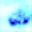

In [5]:
### Try loading the dataset

from utils.config import CIFAR_10_Config
generated_ds_config = CIFAR_10_Config(huggingface_slug=base_save_path, existing_image_column_name="image")
generated_ds_config.dataset[5]["image"]


In [6]:
if GENERATE_NSFW_DISTRIBUTION_DATA:
    print(prompt_nsfw_count)